### **데이터 설명**
(출처 : https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset)

데이터 셋은 PUCPR(브라질 쿠리티바의 사립대학교), UFPR(브라질 쿠리티바의 공립 대학)에서 제공된 공개 데이터이며  
총 3곳의 주차장에서 구름, 비, 맑음 상태에서의 주차장 이미지 데이터입니다.  
사진 전부가 어노테이션이 안되어있기 때문에 주의가 필요합니다.  

--------------------------


1. **데이터 선정 배경**  
  cctv만으로 주차장에 빈 공간이 있는지 판별하기 위해 연속적인 이미지 데이터를 수집했습니다. 

2. **데이터 구성**
  - 주차장 이미지 : 12417  
  - 주차공간 annotation 파일 : 12417

3. **데이터 수집방향**  
  한정된 장소에서 데이터를 수집하다보니 데이터의 편향성이 우려되었습니다.  
또한, 국내 주차장 실정과 거리가 멀다는 특징을 갖고 있어, 서비스 목적에 적합하지 않다고 판단했습니다.  
추가적으로 주차장을 직접 촬영하여 데이터를 수집한 후 모델에 적용해볼 예정입니다.

4. **AI모델링**  
  YOLO, R-CNN 등 object detection에 최적화된 모델을 사용할 예정입니다.

In [ ]:
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

### **데이터 분석 및 시각화**

이미지 필터링을 통해 데이터의 특징을 파악하고 모델 학습에 효과적인 데이터 처리 방법을 모색해보았습니다.

- 이미지 살펴보기

이미지 사이즈는? (1280, 720)


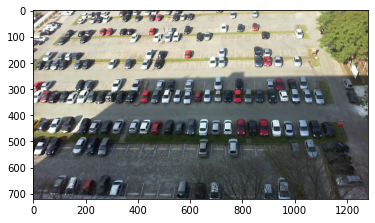

In [ ]:
image = Image.open('**')
print("이미지 사이즈는?", image.size)
plt.imshow(np.array(image))

- annotation 파일의 객체 위치좌표를 읽어와서 이미지에 출력해보기

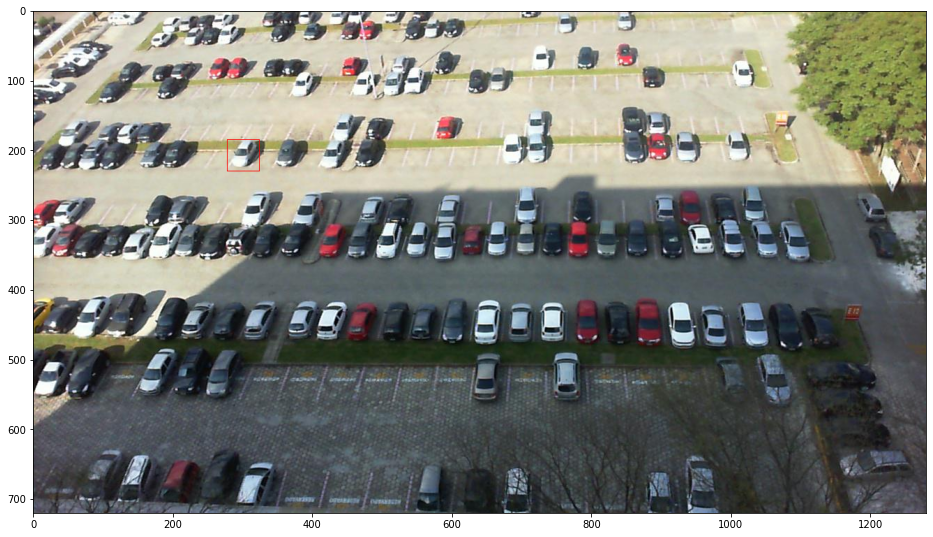

In [ ]:
x1, y1 = 278, 230
x2, y2 = 290, 186
x3, y3 = 324, 185
x4, y4 = 308, 230
img = cv2.imread('**')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = cv2.rectangle(img, (x1, y1), (x3, y3), (255,0,0)) # 좌상 우하 좌표로 그림
fig = plt.figure(num=1, figsize=(16,16))
plt.imshow(result)

- Canny Edge Detection  
canny edge 기법을 사용하여 주차공간 테두리를 검출해보았습니다.

  * 실행방법
    - 1단계 : 노이즈 줄이기  
    - 2단계 : 그래디언트 계산
    - 3단계 : 비최대 억제 (Non-maximum Suppression)
    - 4단계 : 히스테리시스 엣지 트래킹(Hysteresis edge tracking)

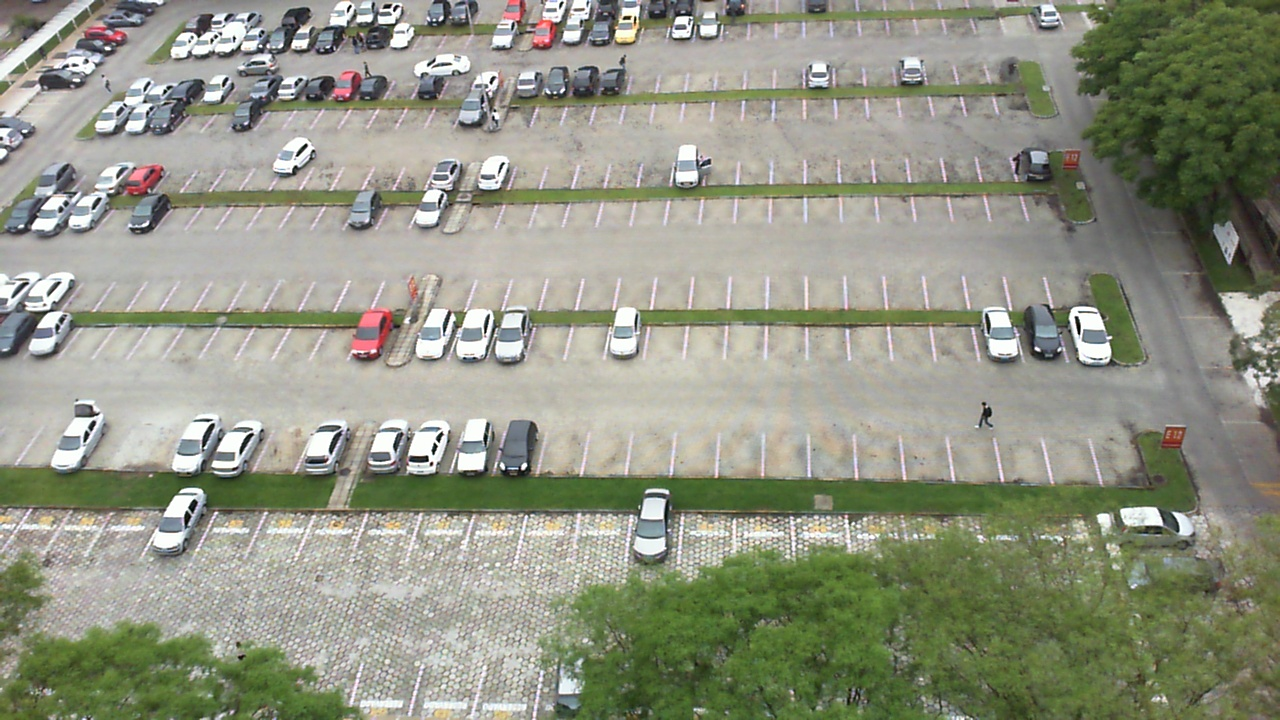

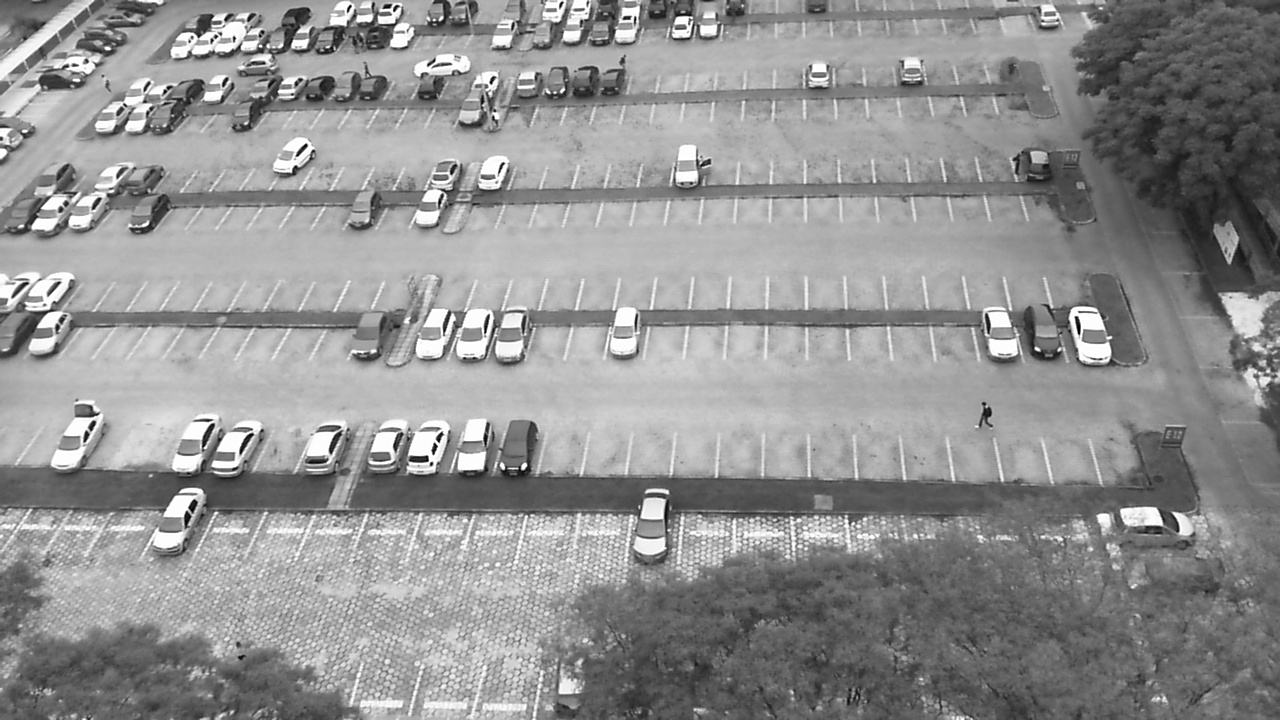

<sobel>
화소값 총합 : (53965694.0, 0.0, 0.0, 0.0) 
화소 최대값 : 255 
화소 최소값 : 0 
행렬 형태 : (720, 1280)
<max_sobel>
화소값 총합 : (19735917.0, 0.0, 0.0, 0.0) 
화소 최대값 : 255 
화소 최소값 : 0 
행렬 형태 : (720, 1280)


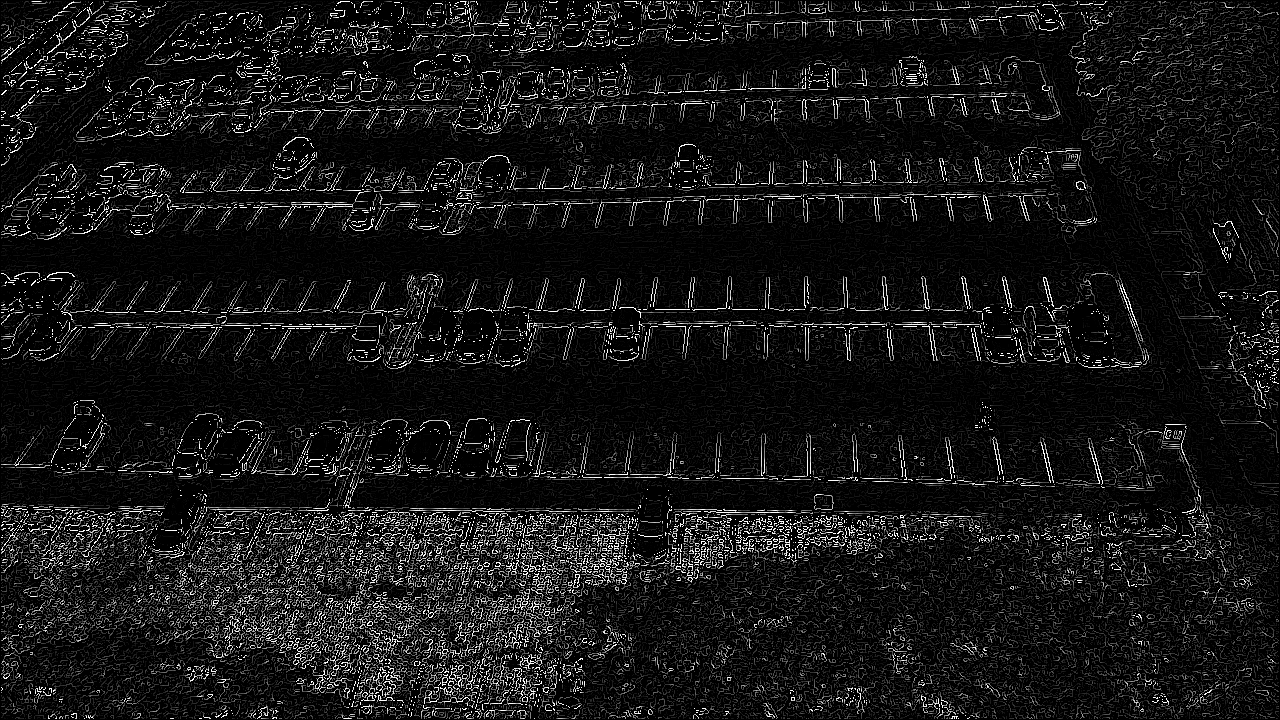

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
{True: 921600}
sobel의 화소값 : 0 
max_sobel의 화소값 : 0
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 14 20 ... 53  0  0]
 ...
 [ 0 34 25 ...  0  0  0]
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 14 20 ... 53  0  0]
 ...
 [ 0 34 25 ...  0  0  0]
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


-1

In [ ]:
import numpy as np, cv2

def nonmax_suppression(sobel, direct):
    rows, cols = sobel.shape[:2]
    dst = np.zeros((rows, cols), np.float32)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # 관심 영역 참조 통해 이웃 화소 가져오기
            values = sobel[i-1:i+2, j-1:j+2].flatten()
            first = [3, 0, 1, 2]
            id = first[direct[i, j]]
            v1, v2 = values[id], values[8-id]

            # # if문으로 이웃 화소 가져오기
            # if direct[i, j] == 0:
            #     v1, v2 = sobel[i, j-1], sobel[i, j+1]
            # if direct[i, j] == 1:
            #     v1, v2 = sobel[i-1, j-1], sobel[i+1, j+1]
            # if direct[i, j] == 2:
            #     v1, v2 = sobel[i-1, j], sobel[i+1, j]
            # if direct[i, j] == 3:
            #     v1, v2 = sobel[i+1, j-1], sobel[i-1, j+1]

            # dst[i, j] = sobel[i, j] if (v1 < sobel[i, j]) & (v2 < sobel[i, j]) else 0
            dst[i, j] = sobel[i, j] if (v1 < sobel[i, j] > v2) else 0
    return dst

def trace(max_sobel, i, j, low):
    h, w = max_sobel.shape
    if (0 <= i < h and 0 <= j < w) == False: return
    if pos_ck[i, j] > 0 and max_sobel[i, j] > low:
        pos_ck[i, j] = 255
        canny[i, j] = 255

        trace(max_sobel, i-1, j-1, low)
        trace(max_sobel, i, j-1, low)
        trace(max_sobel, i+1, j-1, low)
        trace(max_sobel, i-1, j, low)
        trace(max_sobel, i+1, j, low)
        trace(max_sobel, i-1, j+1, low)
        trace(max_sobel, i, j+1, low)
        trace(max_sobel, i+1, j+1, low)

def hysteresis_th(max_sobel, low, high):
    rows, cols = max_sobel.shape[:2]
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if max_sobel[i, j] >= high: trace(max_sobel, i, j, low)

image = cv2.imread("**", cv2.IMREAD_GRAYSCALE)
#image = cv2.resize(image, (321, 600))

image_c = cv2.imread("**", cv2.IMREAD_COLOR)
#image_c = cv2.resize(image_c, (321, 600))
#cv2_imshow(img)
cv2_imshow(image_c)

if image is None: raise Exception("영상파일 읽기 오류")

pos_ck = np.zeros(image.shape[:2], np.uint8)
canny = np.zeros(image.shape[:2], np.uint8)

# 캐니 에지 검출
gaus_img = cv2.GaussianBlur(image, (5, 5), 0.3)
cv2_imshow(gaus_img)
Gx = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 1, 0, 3)
Gy = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 0, 1, 3)

# Gx = cv2.convertScaleAbs(Gx)
# Gy = cv2.convertScaleAbs(Gy)

sobel = cv2.magnitude(Gx, Gy)
sobel = np.clip(sobel, 0, 255).astype(np.uint8)
print(f"<sobel>\n화소값 총합 : {cv2.sumElems(sobel)} \n화소 최대값 : {np.max(sobel)} \n화소 최소값 : {np.min(sobel)} \n행렬 형태 : {sobel.shape}")

directs = cv2.phase(Gx, Gy) / (np.pi/4)
directs = directs.astype(int) % 4
max_sobel = nonmax_suppression(sobel, directs)
max_sobel = max_sobel.astype(np.uint8)
print(f"<max_sobel>\n화소값 총합 : {cv2.sumElems(max_sobel)} \n화소 최대값 : {np.max(max_sobel)} \n화소 최소값 : {np.min(max_sobel)} \n행렬 형태 : {max_sobel.shape}")

cv2_imshow(max_sobel)
# cv2.waitKey(0)

print(sobel >= max_sobel)
checker = sobel >= max_sobel
unique, counts = np.unique(checker, return_counts=True)
checker = dict(zip(unique, counts))
print(checker)

m = 0
n = 0
print(f"sobel의 화소값 : {sobel[m, n]} \nmax_sobel의 화소값 : {max_sobel[m, n]}")

##################
nonmax = max_sobel.copy()


hysteresis_th(max_sobel, 100, 150)

print(nonmax)
print(max_sobel)
print(nonmax == max_sobel)

canny = max_sobel.copy()
canny2 = cv2.Canny(image, 100, 150)

cv2.waitKey(0)

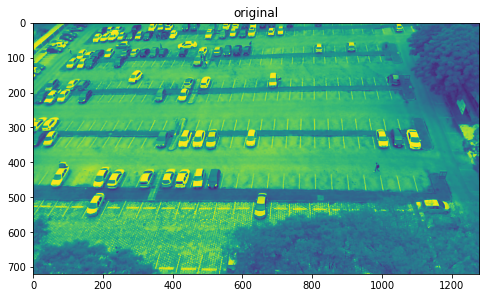

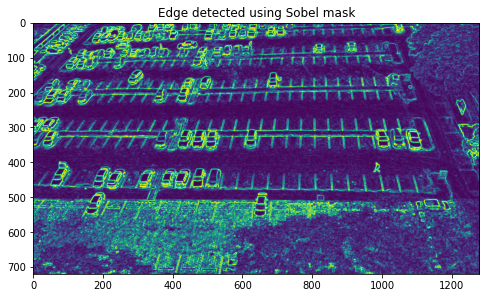

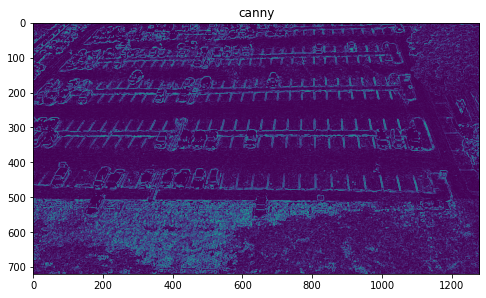

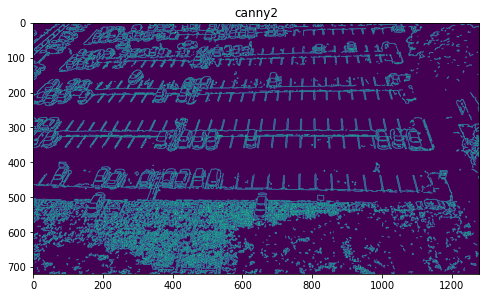

In [ ]:
plt.figure(figsize=(8,12))
img = np.asarray(image)
plt.imshow(img)
plt.title("original")
plt.show()

plt.figure(figsize=(8,12))
img = np.asarray(sobel)
plt.imshow(img)
plt.title("Edge detected using Sobel mask")
plt.show()

plt.figure(figsize=(8,12))
img = np.asarray(canny)
plt.imshow(img)
plt.title("canny")
plt.show()

plt.figure(figsize=(8,12))
img = np.asarray(canny2)
plt.imshow(img)
plt.title("canny2")
plt.show()

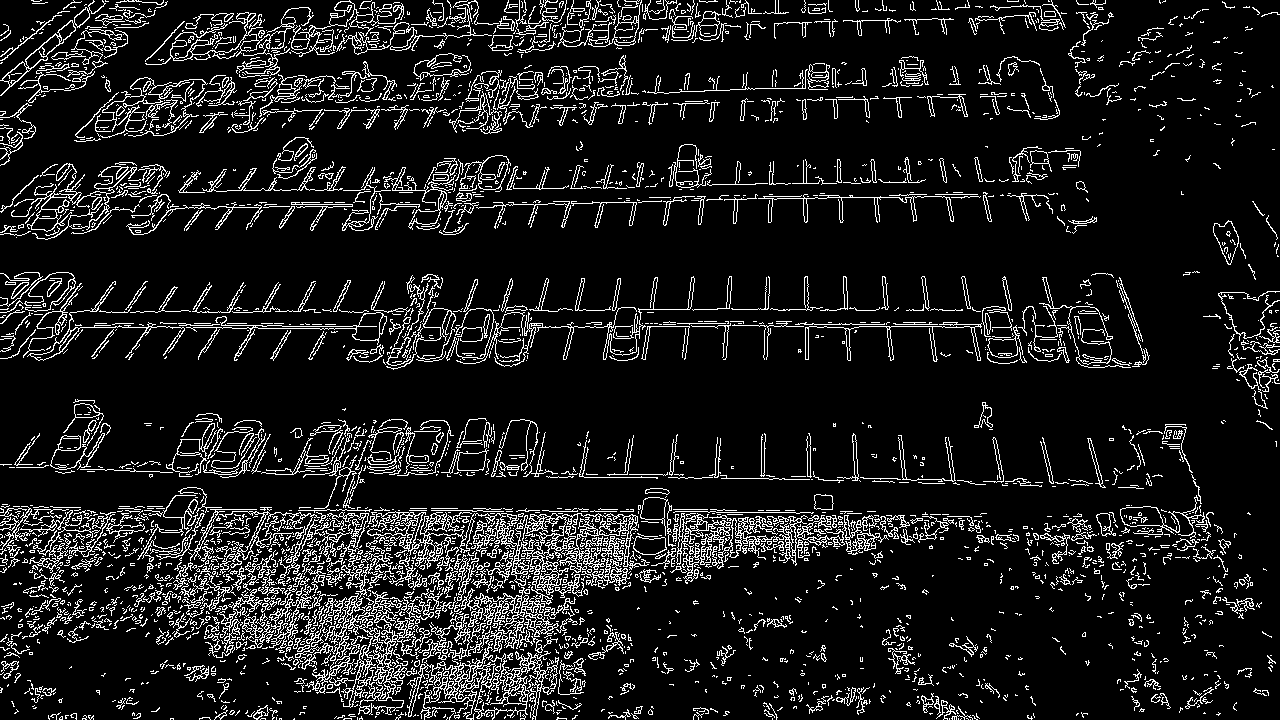

In [ ]:
cv2_imshow(canny2)

- Image Sharpening  
  canny edge 기법을 적용한 이미지에서 주차공간 테두리를 선명하게 검출하기 위해 필터링을 진행했습니다.

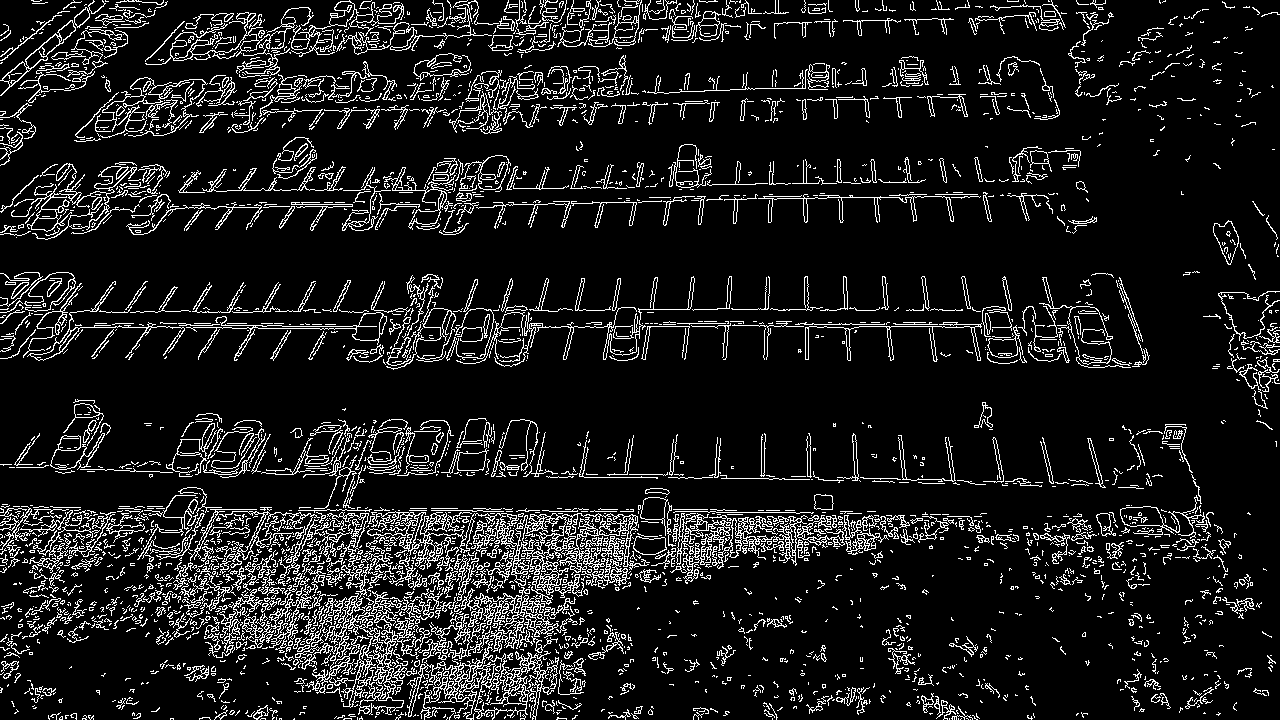

In [ ]:
# 커널 생성(대상이 있는 픽셀을 강조)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 커널 적용 
image_sharp = cv2.filter2D(canny2, -1, kernel)

#plt.title('Original Image')
#cv2_imshow(canny2)


#plt.title('Sharp Image')
cv2_imshow(image_sharp)

### **데이터 전처리**

YOLO 라벨의 특이한 점은 바운딩 박스 그대로 사용하는 것이 아닌 이미지 픽셀 길이에 따른 0~1사이의 비율값을 사용합니다.  
아래 출력값은 각각 (클래스 번호, 원본사진길이 대비 바운딩 박스의 x좌표 길이비율, 원본사진길이 대비 바운딩 박스의 y좌표 길이비율, width, height)를 의미합니다.  
클래스 1은 occupied, 즉 주차공간에 차가 있다는 의미입니다.
이때 이미지 비율의 기준은 좌측 상단입니다.

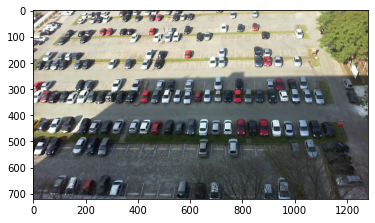

In [ ]:
plt.imshow(np.array(image))

아래 출력값은 위 사진의 바운딩 박스의 좌표를 yolo에 맞게 변환된 값입니다.

In [ ]:
with open('**', "r") as f:
    label_info = f.readlines()
label_info[0].replace('\n', '')

'1 0.23515625 0.2881944444444444 0.0359375 0.0625'

- **바운딩 박스의 좌표가 yolo 라벨로 변환하는 과정**  
일부 데이터 셋은 xml 형태로 저장되어 있는데 바운딩 박스의 4좌표의 정보와 클래스 정보가 있습니다.  
이를 yolo학습을 위해 맞춰 변환이 필요합니다.  
바운딩 박스의 4좌표중 x좌표들의 최대, 최소, y좌표들의 최대, 최소값을 구해  
이미지 사이즈에 맞춰 바운딩 박스의 좌표비율(yolo 라벨)로 변환해줍니다.  
아래는 변환 방법의 한 예시입니다.

In [ ]:
# 위 사진 빨간 영역의 좌표값들
x1, y1 = 278, 230
x2, y2 = 290, 186
x3, y3 = 324, 185
x4, y4 = 308, 230

def convert(size, box):
    
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    result = [x,y,w,h]

    return result

xmin = min(x1, x2, x3, x4)
xmax = max(x1, x2, x3, x4)
ymin = min(y1, y2, y3, y4)
ymax = max(y1, y2, y3, y4)
b = (xmin, ymin, xmax, ymax)
bb = convert((1280,720),b)
bb

[0.23515625, 0.2881944444444445, 0.035937500000000004, 0.0625]